In [1]:
%matplotlib inline
import utils; reload(utils)
from utils import *
import numpy as np
import os
import sys

Using TensorFlow backend.


In [2]:
batch_size = 64

In [3]:
current_dir = os.getcwd()
data_dir = current_dir +'/data/fastai/redux/'
print data_dir

/Users/trinakarmakar/anaconda2/data/fastai/redux/


In [4]:
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

#import modules
from utils import *
from vgg16 import Vgg16

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

In [5]:
from shutil import copyfile

g = glob('*.jpg')
shuf = np.random.permutation(g)
#%mkdir ../valid
for i in range(2000):
    os.rename(shuf[i], '../valid/'+shuf[i])
#%mkdir ../sample
#%mkdir ../sample/train
#%mkdir ../sample/valid
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200):
    copyfile(shuf[i], '../sample/train/'+shuf[i])

g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50):
    copyfile(shuf[i], '../sample/valid/'+shuf[i])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
%cd $data_dir/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $data_dir/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $data_dir/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $data_dir/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

In [6]:
# Create single 'unknown' class for test set
%cd $data_dir/test
%mv *.jpg ./unknown/

/Users/trinakarmakar/anaconda2/data/fastai/redux/test
mv: rename *.jpg to ./unknown/*.jpg: No such file or directory


In [7]:
%cd $data_dir

#Set path to sample/ path if desired
path = data_dir +'sample/'
test_path = data_dir +'test/' #We use all the test data
results_path=data_dir + 'results/'
train_path=path + 'train/'
valid_path=path + 'valid/'

/Users/trinakarmakar/anaconda2/data/fastai/redux


In [8]:
print train_path
print valid_path
print test_path

/Users/trinakarmakar/anaconda2/data/fastai/redux/sample/train/
/Users/trinakarmakar/anaconda2/data/fastai/redux/sample/valid/
/Users/trinakarmakar/anaconda2/data/fastai/redux/test/


In [9]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=64
no_of_epochs=3

In [10]:
#import Vgg16 helper class
vgg = Vgg16()

In [11]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [12]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print "Completed %s fit operations" % no_of_epochs

Running epoch: 0
Epoch 1/1
200/200 [==============================] - 573s - loss: 2.1406 - acc: 0.6400 - val_loss: 1.2082 - val_acc: 0.8800
Running epoch: 1
Epoch 1/1
200/200 [==============================] - 2339s - loss: 1.2580 - acc: 0.8550 - val_loss: 1.0181 - val_acc: 0.8600
Running epoch: 2
Epoch 1/1
200/200 [==============================] - 7203s - loss: 0.7417 - acc: 0.9100 - val_loss: 1.0639 - val_acc: 0.9000

In [ ]:
print test_path
batches, preds = vgg.test(test_path, batch_size = batch_size*2)

/Users/trinakarmakar/anaconda2/data/fastai/redux/test/
Found 12500 images belonging to 1 classes.


In [ ]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
print preds[:5]

filenames = batches.filenames
print filenames[:5]

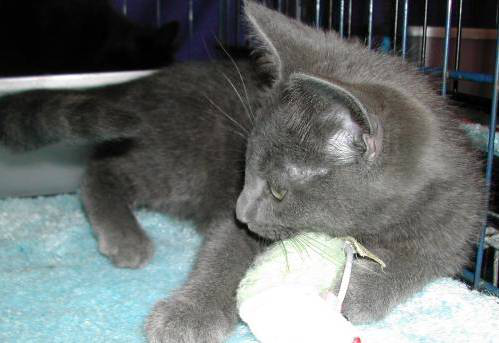

In [13]:
#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(test_path + filenames[2])

In [14]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

In [15]:
vgg.model.load_weights(results_path+latest_weights_filename)

In [16]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 50 images belonging to 2 classes.


In [17]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [18]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 48 correct labels


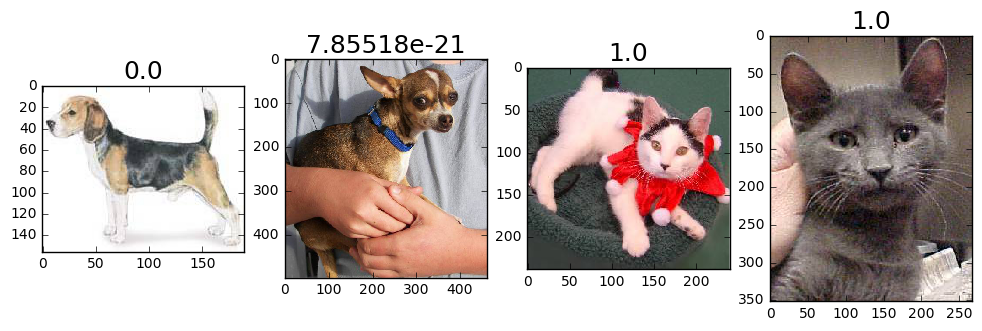

In [19]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 2 incorrect labels


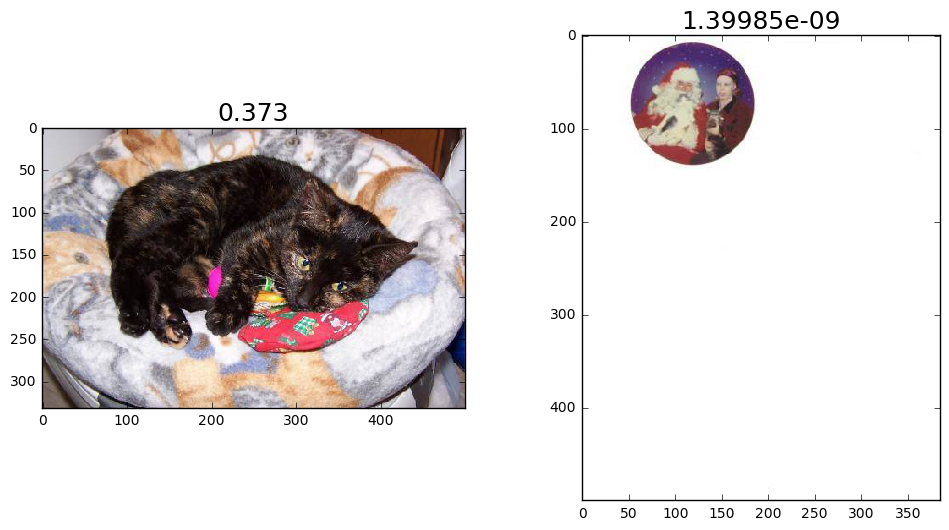

In [20]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 25 confident correct cats labels


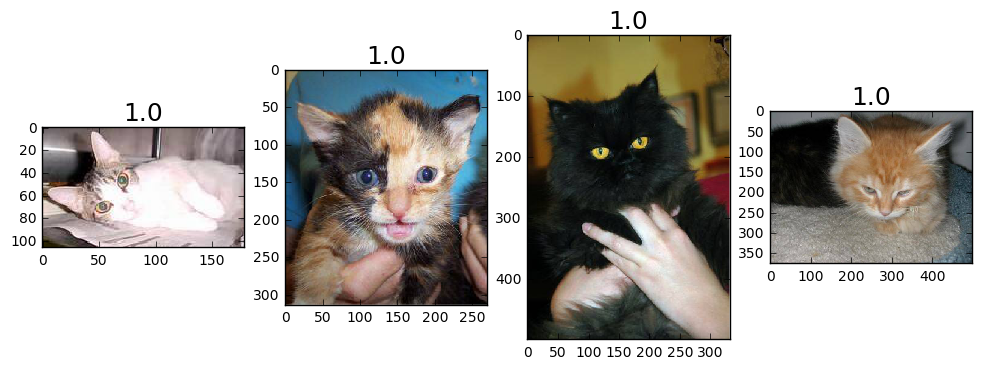

In [21]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print "Found %d confident correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 25 confident correct cats labels


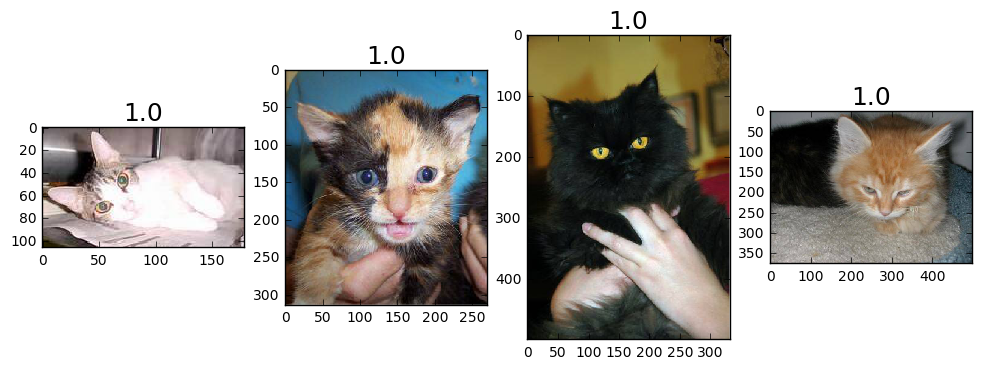

In [22]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print "Found %d confident correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

In [23]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d incorrect cats" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 0 incorrect cats


Found 2 incorrect dogs


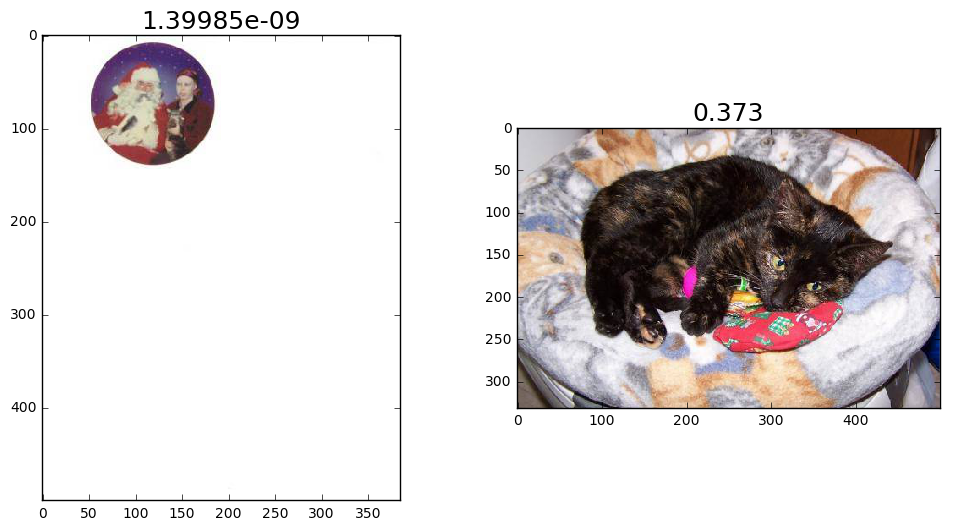

In [24]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found %d incorrect dogs" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

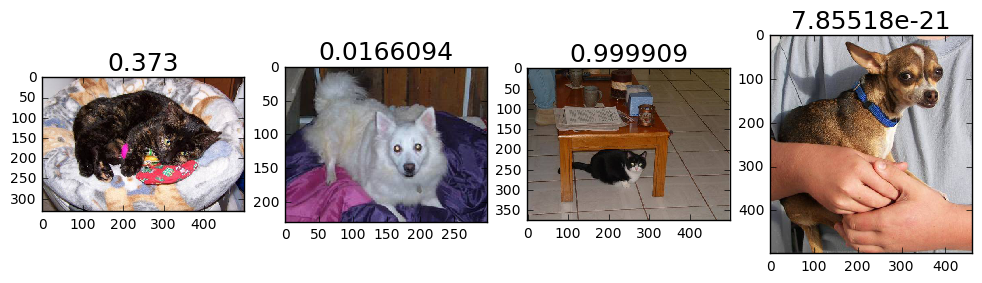

In [25]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[25  2]
 [ 0 23]]


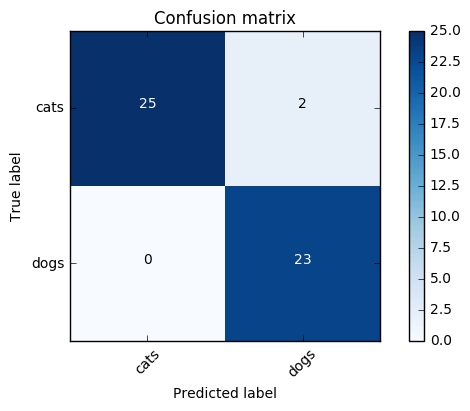

In [27]:
plot_confusion_matrix(cm, val_batches.class_indices)

## Submit Predictions to Kaggle!
Here's the format Kaggle requires for new submissions:
```
imageId,isDog
1242, .3984
3947, .1000
4539, .9082
2345, .0000
```

Kaggle wants the imageId followed by the probability of the image being a dog. Kaggle uses a metric called [Log Loss](http://wiki.fast.ai/index.php/Log_Loss) to evaluate your submission.

In [28]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [29]:
#Grab the dog prediction column
isdog = preds[:,1]
print "Raw Predictions: " + str(isdog[:5])
print "Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)])
print "Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)])

Raw Predictions: [  1.0000e+00   6.3550e-35   7.3348e-23   1.0000e+00   1.0000e+00]
Mid Predictions: [ 0.5305  0.5791  0.5309  0.4996  0.5799  0.445   0.5174  0.4139  0.5454  0.4878  0.515   0.5787]
Edge Predictions: [ 1.  1.  1. ...,  1.  1.  1.]


[Log Loss](http://wiki.fast.ai/index.php/Log_Loss) doesn't support probability values of 0 or 1--they are undefined (and we have many). Fortunately, Kaggle helps us by offsetting our 0s and 1s by a very small value. So if we upload our submission now we will have lots of .99999999 and .000000001 values. This seems good, right?

Not so. There is an additional twist due to how log loss is calculated--log loss rewards predictions that are confident and correct (p=.9999,label=1), but it punishes predictions that are confident and wrong far more (p=.0001,label=1). See visualization below.

In [1]:
#Visualize Log Loss when True value = 1
#y-axis is log loss, x-axis is probabilty that label = 1
#As you can see Log Loss increases rapidly as we approach 0
#But increases slowly as our predicted probability gets closer to 1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

x = [i*.0001 for i in range(1,10000)]
y = [log_loss([1],[[i*.0001,1-(i*.0001)]],eps=1e-15) for i in range(1,10000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()

ValueError: y_true contains only one label (1). Please provide the true labels explicitly through the labels argument.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
rom math import log

In [ ]:
def logloss(true_label, predicted, eps):
    p = np.clip(predicted, eps, 1 - eps)
    if true_label == 1:
        return -log(p)
    else:
        return -log(1 - p)
    x = [i*0.0001 for i in range(1, 10000)]
    y = [logloss(1, i*0.0001, eps = 1e-15) for i in range(1,10000,1)]
    
    plt.plot(x, y)
    plt.axis([-.05, 1.1, -0.8, 10])
    plt.title("Log loss when true label = 1")
    plt.xlabel("predicted probability")
    plt.ylabel("logloss")
    
    plt.show()

In [ ]:
def logloss(true_label, pred_label, eps=1e-15):
    p = np.clip(pred_labels, eps, eps -1)
    if true_label == 1:
        return -logp
    else:
        return -log(1 - p)

In [ ]:
x = [i*0.0001 for i in range(1, 10000)]
y = [logloss(1, i*0.0001, 1e-15) for i in range(1, 10000, 1)]
plt.plot(x, y)
plt.axis[(-0.05, 1.1, -0.8, 10)]
plt.title("Logloss when true label = 1")
plt.xlabel('predicted probability')
plt.ylabel('log loss')
plt.show()

In [2]:
def plot_log_loss_by_epsilon(y_true, y_pred):
    xs = np.linspace(0, 0.1, num=100, endpoint=True)
    df = pd.DataFrame({
        'eps': xs,
        'log_loss': [log_loss(y_true, y_pred, eps=eps) for eps in xs]
    })
    ax = df.plot.line(x='eps', y='log_loss')
    ax.set_ylim(bottom=0)
    print(df.iloc[df['log_loss'].idxmin()])

val_batches, probs = vgg.test(valid_path, batch_size=batch_size)
plot_log_loss_by_epsilon(val_batches.classes, probs)

NameError: name 'vgg' is not defined

In [31]:
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
isdog = isdog.clip(min=0.05, max=0.95)

In [32]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])#Extract imageIds from the filenames in our test/unknown directory 

In [33]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  1.0000e+00,   9.5000e-01],
       [  1.0000e+01,   5.0000e-02],
       [  1.0000e+02,   5.0000e-02],
       [  1.0000e+03,   9.5000e-01],
       [  1.0000e+04,   9.5000e-01]])

In [34]:
%cd $data_dir
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

/Users/trinakarmakar/anaconda2/data/fastai/redux


In [2]:
from IPython.display import FileLink
%cd ./data/fastai/redux/
FileLink('Users/trinakarmakar/anaconda2/data/fastai/redux/'+submission_file_name)

/Users/trinakarmakar/anaconda2/data/fastai/redux


NameError: name 'submission_file_name' is not defined

In [ ]:
import resnet50; reload(resnet50);
from resnet50 import Resnet50;
rno = Resnet50(include_top=False).model
rno.output_shape[1:]

In [ ]:
batches = get_batches(train_path, batch_size=batch_size, shuffle=False)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2, shuffle=False)
val_classes, trn_classes, val_labels, trn_labels, 
        val_filenames, filenames, test_filenames = get_classes(path) 

In [ ]:
val_features = rn0.predict_generator(val_batches, val_batches.nb_sample)
trn_features = rn0.predict_generator(batches. batches.nb_sample)
save_array(model_path, 'rn0_trn_conv_lrg.bc', trn_features)
save_array(model_path, 'rn0_val_conv_lrg.bc', val_batches)

In [ ]:
trn_features = load_array(model_path+'rn0_trn_conv_lrg.bc')
val_features = load_array(model_path+'rn0_val_conv_lrg.bc')

In [ ]:
model = Sequential(get_app_layers(0.01))

In [ ]:
def get_fc_layer(p):
    return [
    BatcNormalization(axis=1, input_shape = rn0.output_shae[1:]),
    Flatten(),
    Dropout(p),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(p/2),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(p),
    Dense(2, activation='softmax')
    ]

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(trn_features, trn_labels, nb_epoch=2,
         batch_size=batch_size, validation_data=(val_features, val_labels))

Global Average Pooling:

In [ ]:
def get_ap_layers(p):
    return [
        GlobalAveragePooling2D(input_shape=rno.output_shape[1:]),
        Dropout(p),
        Dense(2, activation='softmax')
    ]

In [ ]:
model = Sequential(get_ap_layers(0.2))

In [ ]:
model.compile(optimizer=Adam(), loss = 'categotical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(trn_features, trn_labels, nb_epoch=2,
         batch_size=batch_size, validation_data=(val_features, val_labels))

Resnet Large

In [ ]:
rn0 = Resnet50(include_top=False, size=(400,400)).model

In [ ]:
rn0.output_shape[1:]

In [ ]:
batches = get_batches(train_path, batch_size=batch_size, shuffle=False, target_size=(400,400))
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2, shuffle=False, target_size=(400,400))
val_classes, trn_classes, val_labels, trn_labels, 
        val_filenames, filenames, test_filenames = get_classes(path)

In [ ]:
val_features = rn0.predict_generator(val_batches, val_batches.nb_sample)
trn_features = rn0.predict_generator(batches. batches.nb_sample)
save_array(model_path, 'rn0_trn_conv_lrg.bc', trn_features)
save_array(model_path, 'rn0_val_conv_lrg.bc', val_batches)

In [ ]:
model = Sequential(get_ap_layers(0.2))

In [ ]:
model.compile(optimizer=Adam(), loss = 'categotical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(trn_features, trn_labels, nb_epoch=2,
         batch_size=batch_size, validation_data=(val_features, val_labels))